In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import locale
from custom.watermarks import add_watermark
import os
from os import path
from glob import glob
from re import findall
from datetime import datetime

# Set locale to "it" to parse the month correctly
locale.setlocale(locale.LC_ALL, "it_IT.UTF-8")
# plt.style.use('default')
plt.style.use('seaborn-dark')

In [2]:
def date_from_url(csv_path):
    date_ = findall(r"\d+-\d+-\d+", csv_path)[0]
    return datetime.strptime(date_, "%Y-%m-%d")

In [3]:
path = '../dati'
extension = 'csv'
os.chdir(path)
file_names = glob('*.{}'.format(extension))

# ometti il primo file, relativo ai dati riassuntivi
files = np.sort(file_names[1:])
files = files[::-1]

print('Ultimo file', files[0])

Ultimo file data_iss_età_2021-10-06.csv


## Importa dati divisi per fasce d'età
Report del 15 Settembre, https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_15-settembre-2021.pdf
I dati si riferiscono ai 30 giorni precedenti

In [4]:
# recupera data csv
csv_date = date_from_url(files[0])

csv_date_d = csv_date.strftime("%d")
csv_date_m = csv_date.strftime("%B")
report_date = f'{csv_date_d}-{csv_date_m}-{csv_date.year}'

message = f'Report ISS del {csv_date_d} {csv_date_m.capitalize()}: '
message += f'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_{report_date}.pdf. '
message += 'I dati si riferiscono ai 30 giorni precedenti.'

print(message)

Report ISS del 06 Ottobre: https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_06-Ottobre-2021.pdf. I dati si riferiscono ai 30 giorni precedenti.


In [5]:
df_età = pd.read_csv(files[0], sep=';')

df_età

,età,non vaccinati,vaccinati completo,casi non vaccinati,casi vaccinati,ospedalizzati non vaccinati,ospedalizzati vaccinati,terapia intensiva non vaccinati,terapia intensiva vaccinati,decessi non vaccinati,decessi vaccinati
0,12-39,5097573,9572462,30097,8696,1162,89,52,2,16,2
1,40-59,4013196,13222517,18899,13201,1938,258,234,20,127,12
2,60-79,1567153,11643198,6396,10032,1535,794,282,96,402,153
3,80+,264772,4202845,1416,4600,589,1127,36,55,343,413


## Elaborazione dati

In [6]:
# ricava i tassi, dividendo per la popolazione vaccinati e non vaccinata
from custom.preprocessing_dataframe import compute_incidence
df_tassi = compute_incidence(df_età)
df_tassi.index = df_età['età']

df_tassi

,"Casi, non vaccinati","Casi, vaccinati","Ospedalizzati, non vaccinati","Ospedalizzati, vaccinati","In terapia intensiva, non vaccinati","In terapia intensiva, vaccinati","Deceduti, non vaccinati","Deceduti, vaccinati"
età,,,,,,,,
12-39,137.764252,21.196915,5.318871,0.216942,0.238022,0.004875,0.073237,0.004875
40-59,109.881667,23.295363,11.267827,0.455284,1.360512,0.035293,0.738397,0.021176
60-79,95.230013,20.104442,22.854607,1.591201,4.198697,0.192387,5.985376,0.306617
80+,124.786609,25.538256,51.906294,6.256873,3.172541,0.305349,30.227265,2.292891


## Rappresentazione grafica dei risultati

### Funzioni per plot

In [7]:
def which_axe(x):
    axes[x].set_ylabel('Ogni 100.000 persone per ciascun gruppo')
    axes[x].set_xlabel('Fascia d\'età')
    axes[x].legend(['Non vaccinati', 'Vaccinati'])
    axes[x].grid()
    for tick in axes[x].get_xticklabels():
        tick.set_rotation(0)

def add_to_plot():
    plt.ylim(70, 100)
    plt.grid()
    plt.xlabel('Fascia d\'età')
    plt.yticks(np.arange(70, 101, 5), ['70%', '75%', '80%', '85%', '90%', '95%', '100%'])


def which_axe_bar(x):
    axes[x].set_ylim(80, 100)
    axes[x].set_yticks(np.arange(70, 101, 5))
    axes[x].set_yticklabels(['70%', '75%', '80%', '85%', '90%', '95%', '100%'])
    axes[x].set_xlabel('Fascia d\'età')
    axes[x].grid()
    for tick in axes[x].get_xticklabels():
        tick.set_rotation(0)

# colori per plot vaccinati/non vaccinati
palette = ["tab:red", "tab:green"]

### Tassi di contagio

watermark fontsize: 12, angle:-45.0


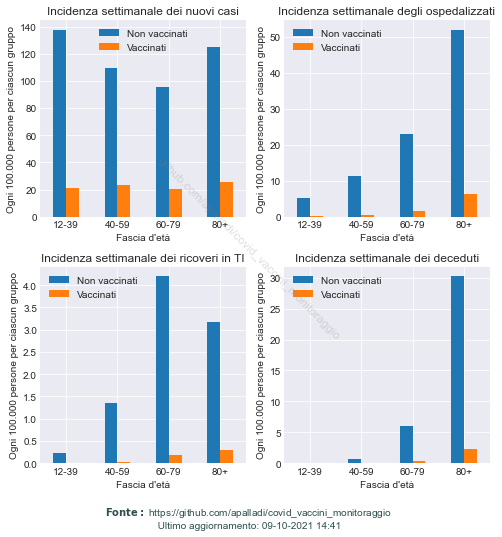

In [8]:
fig, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))

# unpack all the axes subplots
axes = axes2.ravel()

df_tassi.iloc[:, [0, 1]].plot(ax=axes[0],kind='bar')
axes[0].set_title('Incidenza settimanale dei nuovi casi')
which_axe(0)

df_tassi.iloc[:, [2, 3]].plot(ax=axes[1], kind='bar')
axes[1].set_title('Incidenza settimanale degli ospedalizzati')
which_axe(1)

df_tassi.iloc[:, [4, 5]].plot(ax=axes[2], kind='bar')
axes[2].set_title('Incidenza settimanale dei ricoveri in TI')
which_axe(2)

df_tassi.iloc[:, [6, 7]].plot(ax=axes[3], kind='bar')
axes[3].set_title('Incidenza settimanale dei deceduti')
which_axe(3)

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/tassi_per_età.png', dpi=300, bbox_inches="tight")
plt.show()

### Efficacia dei vaccini

In [9]:
efficacia_contagio = (1 - df_tassi.iloc[:, 1]/df_tassi.iloc[:, 0])*100
efficacia_osp = (1 - df_tassi.iloc[:, 3]/df_tassi.iloc[:, 2])*100
efficacia_terint = (1 - df_tassi.iloc[:, 5]/df_tassi.iloc[:, 4])*100
efficacia_decessi = (1 - df_tassi.iloc[:, 7]/df_tassi.iloc[:, 6])*100

watermark fontsize: 14, angle:-45.0


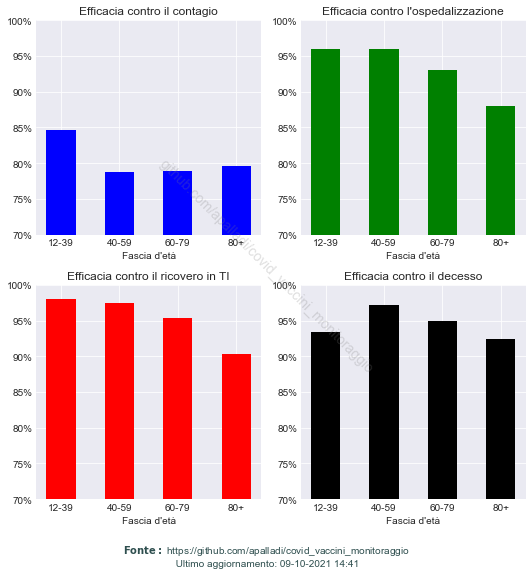

In [10]:
fig = plt.figure(figsize=(7.5, 7.5))

plt.subplot(2, 2, 1)
plt.bar(efficacia_contagio.index, efficacia_contagio, color='blue', width=0.5)
plt.title('Efficacia contro il contagio')
add_to_plot()

plt.subplot(2, 2, 2)
plt.bar(efficacia_osp.index, efficacia_osp, color='green', width=0.5)
plt.title('Efficacia contro l\'ospedalizzazione')
add_to_plot()

plt.subplot(2, 2, 3)
plt.bar(efficacia_terint.index, efficacia_terint, color='red', width=0.5)
plt.title('Efficacia contro il ricovero in TI')
add_to_plot()

plt.subplot(2, 2, 4)
plt.bar(efficacia_decessi.index, efficacia_decessi, color='black', width=0.5)
plt.title('Efficacia contro il decesso')
add_to_plot()

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/efficacia_vaccini.png', dpi=300, bbox_inches="tight")
plt.show()

### Grafico riassuntivo

watermark fontsize: 25, angle:-28.3


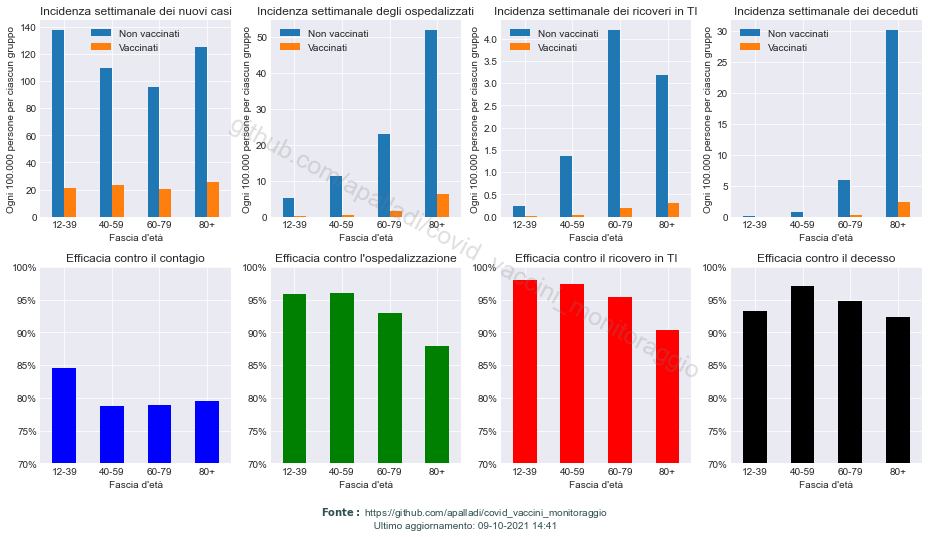

In [11]:
fig, axes2 = plt.subplots(nrows=2, ncols=4, figsize=(13, 7))

# unpack all the axes subplots
axes = axes2.ravel()

df_tassi.iloc[:, [0, 1]].plot(ax=axes[0],kind='bar')
axes[0].set_title('Incidenza settimanale dei nuovi casi')
which_axe(0)

df_tassi.iloc[:, [2, 3]].plot(ax=axes[1], kind='bar')
axes[1].set_title('Incidenza settimanale degli ospedalizzati')
which_axe(1)

df_tassi.iloc[:, [4, 5]].plot(ax=axes[2], kind='bar')
axes[2].set_title('Incidenza settimanale dei ricoveri in TI')
which_axe(2)

df_tassi.iloc[:, [6, 7]].plot(ax=axes[3], kind='bar')
axes[3].set_title('Incidenza settimanale dei deceduti')
which_axe(3)

efficacia_contagio.plot(kind='bar', ax=axes[4], color='blue')
axes[4].set_title('Efficacia contro il contagio')
which_axe_bar(4)

efficacia_osp.plot(kind='bar', ax=axes[5], color='green')
axes[5].set_title('Efficacia contro l\'ospedalizzazione')
which_axe_bar(5)

efficacia_terint.plot(kind='bar', ax=axes[6], color='red')
axes[6].set_title('Efficacia contro il ricovero in TI')
which_axe_bar(6)

efficacia_decessi.plot(kind='bar', ax=axes[7], color='black')
axes[7].set_title('Efficacia contro il decesso')
which_axe_bar(7)

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/tassi_efficacia.png', dpi=300, bbox_inches="tight")
plt.show()

### Focus sugli over 60

In [12]:
df_over60 = df_età.loc[[2,3], ['non vaccinati', 'vaccinati completo', 
                'terapia intensiva non vaccinati', 'terapia intensiva vaccinati',
                'decessi non vaccinati', 'decessi vaccinati']].sum()

df_over60

non vaccinati                       1831925
vaccinati completo                 15846043
terapia intensiva non vaccinati         318
terapia intensiva vaccinati             151
decessi non vaccinati                   745
decessi vaccinati                       566
dtype: int64

In [13]:
over60_array = np.array(df_over60)

label_date = f'{csv_date_d} {csv_date.strftime("%b").capitalize()}'

watermark fontsize: 17, angle:-18.43


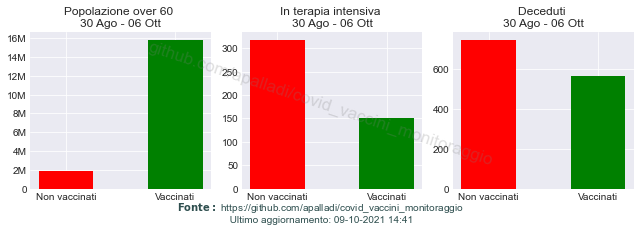

In [14]:
fig = plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.bar(0, over60_array[0], width=0.5, color='red')
plt.bar(1, over60_array[1], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.yticks(10**6*np.arange(0, 17, 2), ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M'])
plt.grid()
plt.title(f'Popolazione over 60 \n30 Ago - {label_date}')

plt.subplot(1, 3, 2)
plt.bar(0, over60_array[2], width=0.5, color='red')
plt.bar(1, over60_array[3], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.grid()
plt.title(f'In terapia intensiva \n30 Ago - {label_date}')

plt.subplot(1, 3, 3)
plt.bar(0, over60_array[4], width=0.5, color='red')
plt.bar(1, over60_array[5], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.grid()
plt.title(f'Deceduti \n30 Ago - {label_date}')

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/focus_over60.png', dpi=300, bbox_inches="tight")
plt.show()

In [15]:
ratio_vacc_novacc = round(over60_array[1]/over60_array[0], 1)
ratio_terint = round(over60_array[2]/over60_array[3], 1)
ratio_dec = round(over60_array[4]/over60_array[5], 1)

print('Rapporto tra vaccinati e non vaccinati', ratio_vacc_novacc)
print('Rapporto tra ricoverati in terapia intensiva (novacc/vacc)', ratio_terint)
print('Rapporto tra deceduti (novacc/vacc)', ratio_dec)

Rapporto tra vaccinati e non vaccinati 8.6
Rapporto tra ricoverati in terapia intensiva (novacc/vacc) 2.1
Rapporto tra deceduti (novacc/vacc) 1.3


In [16]:
print('Peso sul sistema sanitario di un non vaccinato over 60:', round(ratio_vacc_novacc*ratio_terint, 2))
print('Peso sulla mortalità di un non vaccinato over 60:      ', round(ratio_vacc_novacc*ratio_dec, 2))

Peso sul sistema sanitario di un non vaccinato over 60: 18.06
Peso sulla mortalità di un non vaccinato over 60:       11.18
